# SHEF environmental footprint model

The following script calculates the environmental footprint of apartments (also called, dwellings) and occupants (also called, tenants or households) of the apartments for specific buildings owned by the <a href=http://www.nrp73.ch/en/projects/building-construction/ecological-footprint-in-the-housing-sector>Shrinking Housing Environmental Footprint</a> (SHEF, under <a href=http://www.snf.ch/en/researchinFocus/nrp/nfp-73/Pages/default.aspx>NRP73: Sustainable Economy</a>) project building-owner partners: <a href=https://www.abz.ch/>ABZ</a>, <a href=https://www.mobiliar.ch/>Swiss Mobiliar</a> and <a href=https://www.schl.ch/>SCHL</a>. 

_Input_: Data from HBS (<a href = https://www.bfs.admin.ch/bfs/en/home/statistics/economic-social-situation-population/surveys/hbs.html>obtain from Federal Statistical Office of Switzerland</a>) and STATPOP (census) - linked to limited GWR (from <a href='https://www.bfs.admin.ch/bfs/en/home/registers/federal-register-buildings-dwellings.html'>Federal register of buildings</a>) SHEF partner buildings

_Run_: The Jupyter Notebook provides a step-by-step guidance to do the computations

_Output_: One CSV with extended columns (to input file) with occupant and associated apartment (heating and material) footprints 

TOC - overview image below:<a id="toc-main"></a>
- <a href="#abm"> Step 0: Initialising with HBS, STATPOP and GWR tenant-dwelling pairs</a>
- <a href="#consumption"> Step 1: Calculation of occupants' consumption-based footprint</a>
- <a href="#material"> Step 2: Calculation of apartments' material and renovation based footprint</a>
- <a href="#energy"> Step 3: Calculation of apartments' energy(heat/ warmwater)-based footprint</a>
- <a href="#total_impacts"> Step 4: Merge all the final results </a>

Author: Rhythima Shinde, ETH Zurich


<img src="plan/datapipeline-2.PNG">

## 0. Initialisation: output of ABMs  <a id="abm"></a>

<a href="#toc-main">back</a>

In this section, the outputs from following the ABMs are prepared in a format to be passed as input in the respective models 
1. Tenant ABM output (household information) for Consumption footrprint
2. Owner ABM output (building information) for Apartment footprint

In [34]:
#### TEST ######


import pickle
import csv
file = open('model_consumption/Household-Model-Development/init_data/allhhscardemand.pickle','rb')
x = pickle.load(file)
with open('model_consumption/Household-Model-Development/init_data/allhhscardemand.csv', 'w') as output:
    writer = csv.writer(output)
    for key, value in x.items():
        writer.writerow([key, value])
        

In [1]:
%%capture
import pandas as pd
import numpy as np
import pickle
import os

from scipy import stats
import scipy.stats as stats
import statistics
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import random 

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import sklearn.multioutput as sko
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import FunctionTransformer

# import brightway2 as bw #TODO when running LCA for the rebound model here

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [33]:
gws_test = pd.read_csv('model_rene_buildinginfo/Buildinginfo.csv',delimiter= ",",encoding='ISO-8859–1' )
list(gws_test.columns)


['btype',
 'bid',
 'bfsnr',
 'x',
 'y',
 'elevation',
 'delta02',
 'delta10',
 'delta20',
 'area',
 'cells',
 'p0',
 'p5',
 'p10',
 'p15',
 'p20',
 'p25',
 'p30',
 'p35',
 'p40',
 'p45',
 'p50',
 'p55',
 'p60',
 'p65',
 'p70',
 'p75',
 'p80',
 'p85',
 'p90',
 'p95',
 'p100',
 'p1',
 'p2',
 'p3',
 'p4',
 'p96',
 'p97',
 'p98',
 'p99',
 'pavg',
 'pcount',
 'pe0',
 'pe5',
 'pe10',
 'pe15',
 'pe20',
 'pe25',
 'pe30',
 'pe35',
 'pe40',
 'pe45',
 'pe50',
 'pe55',
 'pe60',
 'pe65',
 'pe70',
 'pe75',
 'pe80',
 'pe85',
 'pe90',
 'pe95',
 'pe100',
 'pe1',
 'pe2',
 'pe3',
 'pe4',
 'pe96',
 'pe97',
 'pe98',
 'pe99',
 'peavg',
 'pecount',
 'el0',
 'el5',
 'el10',
 'el15',
 'el20',
 'el25',
 'el30',
 'el35',
 'el40',
 'el45',
 'el50',
 'el55',
 'el60',
 'el65',
 'el70',
 'el75',
 'el80',
 'el85',
 'el90',
 'el95',
 'el100',
 'el1',
 'el2',
 'el3',
 'el4',
 'el96',
 'el97',
 'el98',
 'el99',
 'elavg',
 'elcount',
 'slope0',
 'slope5',
 'slope10',
 'slope15',
 'slope20',
 'slope25',
 'slope30',
 'slop

In [30]:
gws_test['volume'].median()

521.376550661

<p style='color:blue'>USER INPUT NEEDED to chose the strategy no</p>

In [20]:
Strategy_no = 0

# for building model :  oil: 50%, gas: 15%, dis.: 5%, ren: 15%, heatpump 15%
# 0, 1 , NO CHANGE
# 2 , oil to district : oil: -10%, dis.: +10%
# 3 , oil to district and renw: oil: -25%, dis.: +5%, ren: +5%, heatpump +15%
# 4 , oil to district and renw(more): oil: -40%, gas: +10%, dis.: +20%, ren: 15%, heatpump +10%

#### Adapt the owner ABM output files further 

In [ ]:
# (0) Take Owner ABM output file
pd_owner_raw = pd.read_csv('model_owner_ABM/strategy'+str(Strategy_no)+'_output_dw_model.csv',
                           delimiter=',', error_bad_lines=False, encoding='ISO-8859–1')
print(pd_owner_raw.head(),list(pd_owner_raw.columns))

pd_intergation_ownr = pd.read_excel('model_owner_ABM/integration_OwnerABM_Buildingmodel_1.xlsx')

# (1) drop the unwanted columns
pd_intergation_ownr_list_drop = list(pd_intergation_ownr['variables from owner ABM'])
pd_owner_raw=pd_owner_raw[pd_intergation_ownr_list_drop]

# (2) rename the columns
pd_intergation_ownr_list_renamed = list(pd_intergation_ownr['Inputs for building model '])
pd_owner_raw.columns = pd_intergation_ownr_list_renamed
pd.DataFrame.to_csv(pd_owner_raw,'model_owner_ABM/dwelling_data_1.csv',sep=',',index=False)

#### Attach the tenant and the owner ABM output files <a id = 'dwelling_area'></a>

In [ ]:
pd_tenant_raw = pd.read_csv('model_tenant_ABM/strategy'+str(Strategy_no)+'_households_data.csv', sep=',')
pd_owner_raw = pd.read_csv('model_owner_ABM/dwelling_data_1.csv', sep=',')

pd_owner_raw_columns = list(pd_owner_raw.columns)
pd_tenant_raw_columns = list(pd_tenant_raw.columns)

print('owner-columns=', pd_owner_raw_columns ,len(pd_owner_raw_columns),
      '\n\ntenant-columns=',pd_tenant_raw_columns,len(pd_tenant_raw_columns))

pd_owner_tenant_raw = pd.merge(pd_owner_raw,pd_tenant_raw, left_on= ['Time step','Dwelling id'],
                               right_on= ['Step','Current dwelling id'] )


#check if the match is correct based on dwelling sizes
area_tenant_file = [np.round(i) for i in list(pd_owner_tenant_raw['Dwelling area'])]
area_owner_file = [np.round(i) for i in list(pd_owner_tenant_raw['Current dwelling size'])]

# assert area_tenant_file == area_owner_file #TODO for later 0 check which lines has error


pd_owner_tenant_raw=pd_owner_tenant_raw.drop(columns=['Unnamed: 0', 'Step', 'Current dwelling id',
                                                      'Current dwelling size','Postcode'])

print('\n\nall columns=',list(pd_owner_tenant_raw.columns),len(list(pd_owner_tenant_raw.columns)))

pd.DataFrame.to_csv(pd_owner_tenant_raw,'raw/1_households_building_data.csv',sep=',')

#### Attached (owner-tenant) data to ---> input for building model 

In [ ]:
dwelling_columns = list(pd_owner_tenant_raw.columns)[:21]
pd_owner= pd_owner_tenant_raw[dwelling_columns]
print(list(pd_owner.columns), len(list(pd_owner.columns)))
pd.DataFrame.to_csv(pd_owner,'raw/1_dwelling_data.csv',sep=',')

#### Attached (owner-tenant) data to ---> input for consumption model

In [ ]:
# pd_tenant = pd_owner_tenant_raw.drop([ 'Year', 'Month','Dwelling room','Dwelling rent', 'building id', 'Settlment id', 
#                                       'Street address', 'city', 'post code', 'Building total apartment area', 
#                                       'Building no. of dwelling', 'Building height', 'Building Construction year', 
#                                       'Refurbishment year', 'Refurbishment type'],axis=1)
# print(list(pd_tenant.columns),len(list(pd_tenant.columns)))
# pd.DataFrame.to_csv(pd_tenant,'raw/1_households_data_noregion.csv',sep=',')

# # Add the values in the 'char_region_xx' columns for consumption mdoel, based on postcodes in tenant model output
# pd_tenant[['char_georegion_ge','char_georegion_mit','char_georegion_nw',
#     'char_georegion_zh','char_georegion_ost','char_georegion_zen',
#     'char_georegion_ti']] = pd.DataFrame([[0,0,0,0,0,0,0]], index=pd_tenant.index)

# pd_tenant.loc[pd_tenant.canton=='Zurich', 'char_georegion_zh']=1
# pd_tenant.loc[pd_tenant.canton=='Vaud', 'char_georegion_ge']=1

# pd_tenant=pd_tenant.drop(['canton'],axis=1)


# ## Prepare the file for input in consumption model, based on column names of tenant model output file
# pd_consumption_raw_columns = pd.read_excel('model_tenant_ABM/Integration_ABMTenant_Consumptionmodel.xlsx')
# pd_consumption_raw_columns_list = list(pd_consumption_raw_columns['variable_name_consumption_model'])

# pd_tenant.columns = pd_consumption_raw_columns_list

# print(list(pd_tenant.columns), len(list(pd_tenant.columns)))
# pd.DataFrame.to_csv(pd_tenant,'raw/1_households_data.csv',sep=',')

In [ ]:
pd_tenant = pd.read_csv('model_tenant_ABM/strategy'+str(Strategy_no)+'_households_data.csv', sep=',')

# Add the values in the 'char_region_xx' columns for consumption mdoel, based on postcodes in tenant model output
pd_tenant[['char_georegion_ge','char_georegion_mit','char_georegion_nw',
    'char_georegion_zh','char_georegion_ost','char_georegion_zen',
    'char_georegion_ti']] = pd.DataFrame([[0,0,0,0,0,0,0]], index=pd_tenant.index)

pd_tenant.loc[(pd_tenant.Postcode<9000) & (pd_tenant.Postcode>=8000) , 'char_georegion_zh']=1
pd_tenant.loc[(pd_tenant.Postcode<2000) & (pd_tenant.Postcode>=1000), 'char_georegion_ge']=1

pd_tenant=pd_tenant.drop(['Unnamed: 0', 'Year', 'Month', 'Postcode'],axis=1)
print(list(pd_tenant.columns),len(list(pd_tenant.columns)))

## Prepare the file for input in consumption model, based on column names of tenant model output file
pd_consumption_raw_columns = pd.read_excel('model_tenant_ABM/Integration_ABMTenant_Consumptionmodel.xlsx')
pd_consumption_raw_columns_list = list(pd_consumption_raw_columns['variable_name_consumption_model'])

pd_tenant.columns = pd_consumption_raw_columns_list

print(list(pd_tenant.columns), len(list(pd_tenant.columns)))
pd.DataFrame.to_csv(pd_tenant,'raw/1_households_data.csv',sep=',')

#### Attached (owner-tenant) data to ---> input for rebound model <a id='rebound-abm'></a>

In [ ]:
# attach the dwelling rent for income estimation
pd_owner=pd.read_csv('raw/1_dwelling_data.csv',sep=',')[['Dwelling id','Dwelling rent']]
pd_tenant_rebound=pd.merge(pd_tenant,pd_owner,left_on=['dwelling_id'],right_on=['Dwelling id'])

# adapt the tenant database with the selected independent properties of the rebound regression model
pd_rebound_column_name = list(pd.read_excel('model_rebound/integration_ABMTenant_Rebound.xlsx')['name_rebound'])
pd_consum_column_name = list(pd.read_excel('model_rebound/integration_ABMTenant_Rebound.xlsx')['name_consumption']) 

# reindex the columns for input in the regression model
pd_rebound = pd_tenant_rebound.T.reindex(pd_consum_column_name)

pd_rebound = pd_rebound.T

pd_rebound.columns = pd_rebound_column_name

In [ ]:
# edit the columns further
pd_rebound['disposable_income']=pd_rebound['disposable_income']*3 # assumption: rent is 1/3rd of the income
pd.DataFrame.to_csv(pd_rebound,'raw/1_rebound_household_data.csv',sep=',',index=False)

pd_rebound['households_with_a_woman_as_reference_person']=np.random.randint(0,2,pd_rebound.shape[0])

sum1=pd_rebound['female_persons_aged_between_5_and_14_years']+pd_rebound[
    'female_persons_aged_between_15_and_24_years']+pd_rebound[
    'male_persons_aged_between_5_and_14_years']+pd_rebound[
    'male_persons_aged_between_15_and_24_years']
pd_rebound['number_of_students/trainees/apprentices_in_the_household']=np.random.randint(0,sum1+1,pd_rebound.shape[0])

sum2=pd_rebound['female_persons_aged_between_25_and_34_years']+pd_rebound[
    'female_persons_aged_between_35_and_44_years']+pd_rebound[
    'female_persons_aged_between_45_and_54_years']+pd_rebound[
    'female_persons_aged_between_55_and_64_years']+pd_rebound[
    'male_persons_aged_between_25_and_34_years']+pd_rebound[
    'male_persons_aged_between_35_and_44_years']+pd_rebound[
    'male_persons_aged_between_45_and_54_years']+pd_rebound[
    'male_persons_aged_between_55_and_64_years']
pd_rebound['number_of_employed_persons_in_the_household']=np.random.randint(0,sum2+1,pd_rebound.shape[0])

sum3 = pd_rebound['female_persons_aged_between_65_and_74_years']+pd_rebound[
    'female_persons_older_than_75_years']+pd_rebound[
    'male_persons_aged_between_65_and_74_years']+pd_rebound[
    'male_persons_older_than_75_years']
pd_rebound['number_of_employed_persons_in_the_household']=np.random.randint(0,sum3+1,pd_rebound.shape[0])

pd_rebound['number_of_other_persons_in_the_household_(wrt_employment)']=0
pd_rebound['number_of_self_employed_persons_in_the_household']=0
pd_rebound

-------------------------------------------------------------------------------------------------------------------------------
## 1. Occupants' footprint <a id="consumption"></a>

<a href="#toc-main">back</a>

TOC:<a id="toc-consum"></a>
- <a href="#direct_cons">Step 1.a. Direct Consumption-based footprint </a>
- <a href="#rebounds">Step 1.b. Rebounds of the consumption footrpint</a>

### 1a. Direct Consumption-based footprint <a id="direct_cons"></a>

<a href="#toc-cons">back</a>

The following script assigns consumption-archetypes and associated life cycle greenhouse gas emissions that were found in the <a href=https://pubs.acs.org/doi/abs/10.1021/acs.est.8b01452>ES&T-Paper Froemelt et al. 2018</a> to the ABM-households. The assignment is conducted in the same manner as in the <a href="https://onlinelibrary.wiley.com/doi/full/10.1111/jiec.12969">JIE-Paper Froemelt et al. 2020</a> and thus based on the Random-Forest-Classifier that was trained for the respective paper.

*Input*: the user needs to provide the data for the ABM-households in the same structure as demonstrated in test_data.xlsx

*Run*: The Jupyter Notebook provides a step-by-step guidance to do the computations

*Output*: Two EXCEL-files will be stored: 1. Probabilities for each household of behaving like a certain consumption-archetype; 2. LCA-results (IPCC 2013, 100a) aggregated at the main consumption areas for each household in kgCO$_{2}$-eq per year (NOTE: per household, not per capita)

TOC <a id="toc"></a>:
- <a href="#ini">Step 1a.0: Initialisation</a>
- <a href="#prep">Step 1a.1: Data Preparation</a>
- <a href="#probs">Step 1a.2: Estimate Probabilities for Consumption-Archetypes</a>
- <a href="#lca">Step 1a.3: Life Cycle Assessment of Consumption Behaviour</a>

#### 1a.0: Initialisation <a id="ini"></a>

<a href="#toc">back</a>

In [3]:
# Path to data needed
init_data_path = r"model_consumption/Household-Model-Development/init_data"
# Path to output of ABM-model
abm_input_path = r"model_consumption/Household-Model-Development/abm_input"
# Separate path to classifier to save space on disk
clf_path = r"model_consumption"
# Path to results
res_path = r"model_consumption/Household-Model-Development/results"

# Loading classifier (trained and used for JIE-Paper Froemelt et al. 2020)
with open(os.path.join(clf_path, "calibrated_classifier_mob.pickle"), 'rb') as f:
    cccv = pickle.load(f)

# Loading list of attributes (important for correct order of attributes)
with open(os.path.join(init_data_path, 'listofattributes.pickle'), 'rb') as f:
    listofattributes = pickle.load(f)
    
# Loading a translation dict to convert the random-forest-cluster-names to the names used in ES&T-Paper
# Froemelt et al. 2018
with open(os.path.join(init_data_path, 'archetransl.pickle'), 'rb') as f:
    archetranslator = pickle.load(f)

# Loading the LCA-results for greenhouse gas emissions (IPCC 2013, 100a) --> results are in kgCO2-eq/yr
ghg_df = pd.read_pickle(os.path.join(init_data_path, 'archetypes_annual_ghg.pickle'))

In [ ]:
# # adapt the household consumption file slightly 
# nameofABMoutputfile_csv = pd.read_csv('raw/1_households_data.csv', sep=',')
# nameofABMoutputfile_csv = nameofABMoutputfile_csv.iloc[:,5:37] # dropping first four columns which are not needed for the consumption model

# nameofABMoutputfile_csv=nameofABMoutputfile_csv.drop_duplicates()

# print(list(nameofABMoutputfile_csv.columns), len(list(nameofABMoutputfile_csv.columns)))
# nameofABMoutputfile = nameofABMoutputfile_csv.to_excel('model_consumption/Household-Model-Development/abm_input/test_data.xlsx',
#                                                             index = None, header=True) # ASSUMPTION: file is in xlsx-format

In [21]:
fname = os.path.join(abm_input_path, "test_data_"+str(Strategy_no)+".xlsx")
# fname = os.path.join(abm_input_path, "new/test_data.xlsx")
agentHHs = pd.read_excel(fname)

# Probably not necessary, but we are making sure that the attributes are in the correct order

# agentHHs = agentHHs.T.reindex(listofattributes)
# agentHHs = agentHHs.T
# assert list(agentHHs.columns) == listofattributes

#### 1a.1: Data Preparation <a id="prep"></a>

<a href="#toc">back</a>

To impute the missing mobility data, two versions are implemented here. <a href="#mobv1">Version 1</a>: set the mobility demand to the Swiss-wide median (=0.5); <a href="#mobv2">Version 2</a>: Based on the given household characteristics, we estimate a mobility demand with microcensus data from 2015 (https://www.bfs.admin.ch/bfs/de/home/aktuell/neue-veroeffentlichungen.gnpdetail.2017-0076.html).

**<p style="color:blue">USER INPUT NEEDED: CHOOSE <a href="#mobv1">VERSION 1</a> OR <a href="#mobv2">VERSION 2</a></p>**

##### Impute mobility demand (Version 1, set to median) <a id="mobv1"></a> and jump to <a href="#probs">1a.2: Probabilities for Consumption-Archetypes</a>

In [22]:
agentHHs['mobility'] = 0.5

##### Impute mobility demand (Version 2, use microcensus 2015) <a id="mobv2"></a>

In [ ]:
%%time
# daily distance in km from microcensus 2015 (motorisierter Individualverkehr):
# Verkehrsverhalten der Bevölkerung, Kenngrössen 2015 - Schweiz
mc_data = {
    'gender': {
        'm': 29.242695698,
        'f': 19.595522015
    },
    'age': {
        '0617': 13.252892803,
        '1824': 24.792044371,
        '2544': 31.295384917,
        '4564': 28.671073552,
        '6579': 16.968762215,
        '8099': 6.5412771519
        
    },
    'inc': {
        '<4000': 13.196680471,
        '40018000': 24.841538427,
        '800112000': 32.139251131,
        '>12000': 34.034484978
    }
}

# Very probably, we will only have data on gender and age for the ABM-households --> income will not be considered
# The following matchings are simplified assumptions to align the microcensus data with the expected data from the
# ABM-model. If more detailed data is provided by the ABM-model the whole cell needs to be revised!
matchABMMC = {
    '0514': '0617',
    '1524': '1824',
    '2534': '2544',
    '3544': '2544',
    '4554': '4564',
    '5564': '4564',
    '6574': '6579',
    '7599': '8099'
}

# Estimate daily mobility demand based on gender
genderestimate = mc_data['gender']['f'] * \
agentHHs[[c for c in agentHHs.columns if 'fem' in c and not '0004' in c]].sum(axis=1) \
+ mc_data['gender']['m'] * agentHHs[[c for c in agentHHs.columns if 'male' in c and not '0004' in c]].sum(axis=1)

# Estimate daily mobility demand based on age structure
ageestimate = pd.Series(0, index=agentHHs.index)
for ky in matchABMMC.keys():
    ageestimate += (mc_data['age'][matchABMMC[ky]] * agentHHs[[c for c in agentHHs.columns if ky in c]].sum(axis=1))

# Take the average of both estimates
agentHHs['mobility'] = 0.5 * genderestimate + 0.5 * ageestimate

# Convert from daily to yearly demand
agentHHs['mobility'] *= 365

# Load car demand of all Swiss households (mobility model --> see JIE-Paper Froemelt et al. 2020)
hhcardemand = pd.read_pickle(os.path.join(init_data_path, 'allhhscardemand.pickle'))

# Compute percentile score of agent-HHs' mobility demand
for hhid in agentHHs.index:
    agentHHs.loc[hhid, 'mobility'] = stats.percentileofscore(hhcardemand.values, agentHHs.loc[hhid, 'mobility']) / 100
    
del ageestimate, genderestimate, hhcardemand

#### 1a.2: Probabilities for Consumption-Archetypes <a id="probs"></a>

<a href="#toc">back</a>

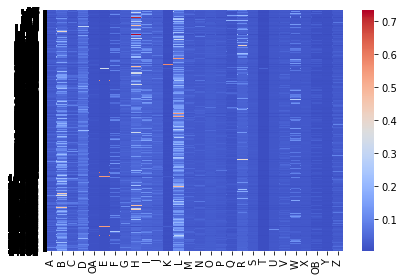

In [23]:
# For each ABM-household we compute the probability of being a certain consumption-archetype
probs = cccv.predict_proba(agentHHs.values)
probs_df = pd.DataFrame(data=probs, index=agentHHs.index, columns=[archetranslator[c] for c in cccv.classes_])

# Visualise the probabilities
sns.heatmap(probs_df, cmap='coolwarm', xticklabels=True, yticklabels=True)
plt.tight_layout()

# Store the probabilities as excel-file
probs_df.to_excel(os.path.join(res_path, 'res_archetypes_probas.xlsx'))

#### 1a.3: Life Cycle Assessment of Consumption <a id="lca"></a>

<a href="#toc">back</a>

Before a life cycle assessment of consumption behaviour can be performed, we have to choose a consumption-archetype for each ABM-household. There are two options for this: <a href="#lcav1">Option 1</a> is a manual user choice; <a href="#lcav2">Option 2</a> automatically chooses the most probable archetype.

**<p style="color:blue">USER INPUT NEEDED: CHOOSE <a href="#lcav1">OPTION 1</a> OR <a href="#lcav2">OPTION 2</a></p>**

##### Option 1 (automatic selection of most probable archetype) <a id="lcav2"></a> 

In [24]:
archechoice = dict()
maxprobas = probs_df.T.idxmax()
for hhid in agentHHs.index:
    archechoice[hhid] = maxprobas[hhid]

##### Option 2 (manual selection of archetypes) <a id="lcav1"></a>

<p style="color:blue">USER INPUT NEEDED: ENTER THE ARCHETYPE-NAME (ACCORDING TO THE ES&T-PAPER FROEMELT ET AL. 2018) FOR EACH HOUSEHOLD</p> 

In [ ]:
archechoice = dict()
for hhid in agentHHs.index:
    archechoice[hhid] = input('HH-ID: {} --> Archetype: '.format(hhid))

##### In the final step, we assign the LCA-results to ABM-households and save them as an EXCEL-file

**NOTE: The results are in kg CO$_{2}$-eq per year on a household level (not per capita!)**

In [ ]:
# Assign the aggregated LCA-GHG-results to the ABM-households
hh_lca_res = pd.DataFrame(np.nan, index=agentHHs.index, columns=[c for c in ghg_df.columns if not c.endswith('_cap')])
for hhid in hh_lca_res.index:
    archename = archechoice[hhid]
    hh_lca_res.loc[hhid, hh_lca_res.columns] = ghg_df.loc[archename, hh_lca_res.columns]
hh_lca_res.to_excel(os.path.join(res_path, 'res_hhlca.xlsx'))

In [ ]:
## attach the footprint back to tenants (1_household_data.csv)
pd_result_consum_fp = pd.read_excel('model_consumption/Household-Model-Development/results/res_hhlca.xlsx',index_col=0)
# pd_result_consum_fp = pd.concat([pd_tenant,pd_consum_fp],axis=1,sort=False)

pd_result_consum_fp=pd_result_consum_fp.rename(columns={'total':'total_occupant_footprint'})

pd_result_consum_fp['housing_all']=pd_result_consum_fp['housing']+pd_result_consum_fp['furnishings']
pd_result_consum_fp['food_all']=pd_result_consum_fp['food']+pd_result_consum_fp['restaurantshotels']
pd_result_consum_fp['transport_all']=pd_result_consum_fp['transport']+pd_result_consum_fp['recreation']


pd.DataFrame.to_csv(pd_result_consum_fp,'postprocessing/1a_consumption/res_hhlca.csv')

pd_result_consum_fp[['food_all','clothing','housing_all','transport_all','total_occupant_footprint']].mean()

-------------------------------------------------------------------------------------------------------------------------------
### 1b. Rebound consumption-based footprint <a id="rebounds"></a>

<a href="#toc-consum">back</a>

Aim: Quantify the environmental impact due to the savings due to consumption expenses

_Input_: The household budet survey files to train the data 

_Model_: A random forest or Artificial neural network model 
<a href='https://ifu-esd-srv-4.ethz.ch/jupyterhub/user/shinder/notebooks/0_work/Models/1_consumption_movement/3_Rebound/5_final_model/rebound-model/rebound_model.ipynb'>Link to the full code</a>

_Output_: The rebound expenses and environmental footprints of the households 
<p style='color:red'>[WIP] Detailed LCA of the consumption expenses as outputs</p>

TOC<a id="toc-rebound"></a>

- <a href="#ini-rebound"> Step 0: Initialisation</a>
- <a href="#model-rebound"> Step 1: Model </a>
- <a href="#post-rebound"> Step 2: Postprocessing </a>
- <a href="#lca-rebound"> Step 3: LCA </a>

#### 1b.0. Initialisation <a id = 'ini-rebound'></a>

<a href="#toc-rebound">back</a>

<p style='color:blue'>USER INPUT NEEDED: based on the expected rebound analysis, change the following values</p>

Data Parameters
- (1) **habe_file_folder** -> For the year 2009-11, the main Household budget survey(habe/hbs) file is provided by <a href= https://pubs.acs.org/doi/full/10.1021/acs.est.8b01452>A.Froemelt</a>. It is modified based on original HBS(HABE) data that we <a href = https://www.bfs.admin.ch/bfs/en/home/statistics/economic-social-situation-population/surveys/hbs.html>obtain from Federal Statistical Office of Switzerland</a>. It is further modiefied in the <a href='https://ifu-esd-srv-4.ethz.ch/jupyterhub/user/shinder/notebooks/0_work/Models/1_consumption_movement/3_Rebound/5_final_model/rebound-model/rebound_model.ipynb'>original rebound code</a> in the preprocessing section
- (2) **dependent_indices** -> based on the HBS column indices, this file lists the relevant consumption expense parameters which are predicted 
- (3) **independent_indices** -> the HBS column indices which define the household socio-economic properties
- (4) **target_data** -> Selects the target dataset to predict the results. For this project on housing industry, it is the partner dataset 'ABZ', 'SCHL' or 'SM' (and here takes the input from the <a href='#rebound-abm'>ABMs output</a>)

Model parameters
- (1) **iter_n** -> no.of iterations of runs
- (2) **model_name** -> Random Forest (RF) or ANN (Artificial Neural Network)
- (3) **income_groups** -> for postprocessing, the number of income groups on which the result is desired

In [ ]:
# all the preprocessed files (training data) in the original code (check link above to the code to generate them)
habe_file_folder='model_rebound/preprocessing'

# setting model parameters
iter_n=2
model_name='RF' # 'RF' or 'ANN'
income_groups=5 

scenarios = {'baseline_2011':500}
target_data = 'ABZ_ABM' 
target_data_file= pd.read_csv('raw/1_rebound_household_data.csv',sep=',') 
pd.DataFrame.to_csv(target_data_file,'model_rebound/target_'+target_data+'.csv',sep=',',index=False)

idx_column_savings_cons = 289 #289 = 'net_rent_and_mortgage_interest_of_principal_residence'   

In [ ]:
dependent_indices= 'model_rebound/dependent_housing.csv'
dependent_indices_pd = pd.read_csv(dependent_indices, delimiter=',', encoding='ISO-8859–1')
dependent_indices_pd_name = pd.read_csv(dependent_indices,sep=',')["name"]
dependentsize=len(list(dependent_indices_pd_name))

independent_indices='model_rebound/independent.csv' 
independent_indices_pd = pd.read_csv(independent_indices, delimiter=',', encoding='ISO-8859–1')
list_independent_columns = pd.read_csv(independent_indices, delimiter=',', encoding='ISO-8859–1')['name'].to_list()
list_dependent_columns = pd.read_csv(dependent_indices, delimiter=',', encoding='ISO-8859–1')['name'].to_list()


<p style='color:blue'>USER INPUT NEEDED:Chose whether to normalise or not</p>

In [ ]:
input = 'no-normalise' #or 'normalise'

if input =='normalise':
    def normalise_partner(i,key):
        pd_df_partner = pd.read_csv('model_rebound/target_'+target_data+'.csv',delimiter=',')
        df_complete =  pd.read_csv('model_rebound/preprocessing/1_habe_rename_removeoutliers.csv',delimiter=',') 
        pd_df_partner['disposable_income'] = pd_df_partner['disposable_income'] + i

        for colsss in list_independent_columns:
            min_colsss = df_complete[[colsss]].quantile([0.01]).values[0]
            max_colsss = df_complete[[colsss]].quantile([0.99]).values[0]
            pd_df_partner[[colsss]] = (pd_df_partner[[colsss]] - min_colsss) / (max_colsss - min_colsss)

        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,30]<=1]
        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,32]<=1]
        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,33]>=0] #todo remove rows with normalisation over the range

        pd.DataFrame.to_csv(pd_df_partner,'model_rebound/preprocessing/5_final_'+ target_data + 
                            '_independent_final_'+str(i)+'.csv',sep=',',index=False)
        return pd_df_partner

if input =='no-normalise':
    def normalise_partner(i,key):
        pd_df_partner = pd.read_csv('model_rebound/target_'+target_data+'.csv',delimiter=',')
        df_complete =  pd.read_csv('model_rebound/preprocessing/1_habe_rename_removeoutliers.csv',delimiter=',') 
        pd_df_partner['disposable_income'] = pd_df_partner['disposable_income'] + i

        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,30]<=1]
        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,32]<=1]
        # pd_df_partner = pd_df_partner[pd_df_partner.iloc[:,33]>=0] #todo remove rows with normalisation over the range


        pd.DataFrame.to_csv(pd_df_partner,'model_rebound/preprocessing/5_final_'+ target_data + '_independent_final_'+str(i)+'.csv',sep=',',index=False)
        return pd_df_partner
    
for key in scenarios:
    list_incomechange=[0,scenarios[key]]
    for i in list_incomechange:
        df_normalise_partner_file = normalise_partner(i,key)

#### 1b.1. Model <a id = 'model-rebound'></a>

<a href="#toc-rebound">back</a>

In [ ]:
def to_haushalts(values,id_ix=0):
    haushalts = dict()
    haushalt_ids = np.unique(values[:,id_ix])
    for haushalt_id in haushalt_ids:
        selection = values[:, id_ix] == haushalt_id
        haushalts[haushalt_id] = values[selection]
    return haushalts

def split_train_test(haushalts,length_training,month_name,row_in_chunk):
    train, test = list(), list()
    cut_point = int(0.8*length_training)  # 0.9*9754 # declare cut_point as per the size of the imputed database #TODO check if this is too less
    print('Month/cluster and cut_point',month_name, cut_point)
    for k,rows in haushalts.items():
        train_rows = rows[rows[:,row_in_chunk] < cut_point, :]
        test_rows = rows[rows[:,row_in_chunk] > cut_point, :]
        train.append(train_rows[:, :])
        test.append(test_rows[:, :])
    return train, test

In [ ]:

### NORMALISATION

if input =='normalise':

    def df_habe_train_test(df,month_name,length_training):
        df=df.assign(id_split = list(range(df.shape[0])))
        train, test = split_train_test(to_haushalts(df.values),length_training,month_name,row_in_chunk=df.shape[1]-1)

        train_rows = np.array([row for rows in train for row in rows])
        test_rows = np.array([row for rows in test for row in rows])

        independent = list(range(0,independent_indices_pd.shape[0]))
        dependent =  list(range(independent_indices_pd.shape[0]+1,
                                independent_indices_pd.shape[0]+dependent_indices_pd.shape[0]+1))

        trained_independent = train_rows[:, independent]
        trained_dependent = train_rows[:, dependent]
        test_independent = test_rows[:, independent]
        test_dependent = test_rows[:, dependent]

        ## OPTIONAL lines FOR CHECK - comment if not needed
        np.savetxt('model_rebound/preprocessing/trained_dependent_nonexp.csv', trained_dependent, delimiter=',')    
        np.savetxt('model_rebound/preprocessing/trained_dependent.csv', np.expm1(trained_dependent),delimiter=',')
        np.savetxt('model_rebound/preprocessing/trained_independent.csv', trained_independent, delimiter=',')
        np.savetxt('model_rebound/preprocessing/test_dependent.csv', np.expm1(test_dependent), delimiter=',')
        np.savetxt('model_rebound/preprocessing/test_independent.csv', test_independent, delimiter=',')

        return trained_independent,trained_dependent,test_independent,test_dependent

    def df_partner_test(y):
        df_partner = pd.read_csv('model_rebound/preprocessing/5_final_' + target_data + '_independent_final_' + str(y) + '.csv',
                                 delimiter=',')
        length_training = df_partner.shape[0]
        train_partner, test_partner = split_train_test(to_haushalts(df_partner.values),length_training,month_name,1) 
        train_rows_partner = np.array([row for rows in train_partner for row in rows])
        new_independent = list(range(0, 39)) # number of columns of the independent parameters
        train_partner_independent = train_rows_partner[:, new_independent]

        ### Optional lines for CHECK - comment if not needed
        np.savetxt('model_rebound/preprocessing/train_partner_independent_' + model_name + '_' + str(y) + '.csv',
                   train_partner_independent, delimiter=',')

        return train_partner_independent
    
# NO-NORMALISATION
if input =='no-normalise':
    def df_habe_train_test(df,month_name,length_training):
        df=df.assign(id_split = list(range(df.shape[0])))
        train, test = split_train_test(to_haushalts(df.values),length_training,month_name,row_in_chunk=df.shape[1]-1)

        train_rows = np.array([row for rows in train for row in rows])
        test_rows = np.array([row for rows in test for row in rows])

        independent = list(range(0,independent_indices_pd.shape[0]))
        dependent =  list(range(independent_indices_pd.shape[0]+1,
                                independent_indices_pd.shape[0]+dependent_indices_pd.shape[0]+1))

        trained_independent = train_rows[:, independent]
        trained_dependent = train_rows[:, dependent]
        test_independent = test_rows[:, independent]
        test_dependent = test_rows[:, dependent]

        ## OPTIONAL lines FOR CHECK - comment if not needed
        # np.savetxt('raw/checks/trained_dependent_nonexp_'+str(month_name)+'.csv', trained_dependent, delimiter=',')    
        # np.savetxt('raw/checks/trained_independent_nonexp_'+str(month_name)+'.csv', trained_independent, delimiter=',')
        np.savetxt('model_rebound/preprocessing/test_dependent_'+str(month_name)+'.csv', test_dependent,delimiter=',')    
        np.savetxt('model_rebound/preprocessing/test_independent_'+str(month_name)+'.csv', test_independent, delimiter=',')

        return trained_independent,trained_dependent,test_independent,test_dependent
    
    def df_partner_test(y):
        df_partner = pd.read_csv('model_rebound/preprocessing/5_final_' + target_data + '_independent_final_' + str(y) + '.csv',
                                 delimiter=',')
        length_training = df_partner.shape[0]
        train_partner, test_partner = split_train_test(to_haushalts(df_partner.values),
                                                       length_training,cluster_number,1) 
        train_rows_partner = np.array([row for rows in train_partner for row in rows])
        new_independent = list(range(0, 39))
        train_partner_independent = train_rows_partner[:, new_independent]

        ### Optional lines for CHECK - comment if not needed
        np.savetxt('model_rebound/preprocessing/train_partner_independent_' + model_name + '_' + str(y) + '.csv',
                   train_partner_independent, delimiter=',')

        return train_partner_independent

#### Prediction

In [ ]:
## NORMALISATION

if input =='normalise':

    def fit_predict_cluster(i,y,cluster_number,key):
        df = pd.read_csv('model_rebound/preprocessing/4_habe_deseasonal_cluster_'+str(cluster_number)+'_normalised.csv',
                         delimiter=',',error_bad_lines=False, encoding='ISO-8859–1')
        length_training = df.shape[0]
        trained_independent, trained_dependent, test_independent, test_dependent = df_habe_train_test(df,
                                                                                                      str(cluster_number),
                                                                                                      length_training)
        train_partner_independent = df_partner_test(y)
        
        if model_name == 'ANN':
            estimator = KerasRegressor(build_fn=ANN)
            estimator.fit(trained_independent, trained_dependent, epochs=100, batch_size=5, verbose=0)

            ### PREDICTION FROM HERE
            prediction_nn = estimator.predict(train_partner_independent)
            prediction_nn_denormalised = np.expm1(prediction_nn)
            np.savetxt('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) + '.csv', prediction_nn_denormalised, delimiter=',')

            ### TEST PREDICTION
            prediction_nn_test = estimator.predict(test_independent)
            prediction_nn_test_denormalised = np.expm1(prediction_nn_test)
            np.savetxt('model_rebound/postprocessing/predicted_test' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) + '.csv', prediction_nn_test_denormalised, delimiter=',')

            ### CROSS VALIDATION FROM HERE
            kfold = KFold(n_splits=10, random_state=12)
            results1 = cross_val_score(estimator, test_independent, test_dependent, cv=kfold)
            print("Results_test: %.2f (%.2f)" % (results1.mean(), results1.std()))

        if model_name == 'RF':
            estimator = sko.MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_features=39, random_state=30))
            estimator.fit(trained_independent, trained_dependent)

            ### PREDICTION FROM HERE
            prediction_nn = estimator.predict(train_partner_independent)
            prediction_nn_denormalised = np.expm1(prediction_nn)
            np.savetxt('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) + '.csv', prediction_nn_denormalised, delimiter=',')

             ### TEST PREDICTION
            prediction_nn_test = estimator.predict(test_independent)
            prediction_nn_test_denormalised = np.expm1(prediction_nn_test)
            np.savetxt('model_rebound/postprocessing/predicted_test' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) + '.csv', prediction_nn_test_denormalised, delimiter=',')        

            #### CROSS VALIDATION FROM HERE
            kfold = KFold(n_splits=10, random_state=12)
            # results1 = cross_val_score(estimator, test_independent, test_dependent, cv=kfold)
            results2 = r2_score(test_dependent,prediction_nn_test)
            results3 = mean_squared_error(test_dependent,prediction_nn_test)
            results4 = explained_variance_score(test_dependent,prediction_nn_test)
            # print("cross_val_score: %.2f (%.2f)" % (results1.mean(), results1.std()))
            print("r2_score: %.2f " % results2)
            print("mean_squared_error: %.2f " % results3)
            print("explained_variance_score: %.2f " % results4)

### FOR NO NORMALISATION

if input =='no-normalise':
    def fit_predict_cluster(i,y,cluster_number,key):
        df_non_normalised = pd.read_csv('model_rebound/preprocessing/4_habe_deseasonal_cluster_'+
                                        str(cluster_number)+ '_short.csv', delimiter=',',
                                        error_bad_lines=False, encoding='ISO-8859–1')
        length_training = df_non_normalised.shape[0]
        trained_independent, trained_dependent, test_independent, test_dependent = df_habe_train_test(df_non_normalised,
                                                                                                      str(cluster_number),
                                                                                                      length_training)
        train_partner_independent = df_partner_test(y)
        
        ### Additional for the HBS test data subset
        # test_new_independent = df_test(y,1) # chosing just one cluster here
        # sratified_independent = df_stratified_test(y)
    
        if model_name == 'ANN':
            estimator = KerasRegressor(build_fn=ANN)
            estimator.fit(trained_independent, trained_dependent, epochs=100, batch_size=5, verbose=0)

            ### PREDICTION FROM HERE
            prediction_nn = estimator.predict(train_partner_independent)
            np.savetxt('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) +'.csv', prediction_nn, delimiter=',')

            ### TEST PREDICTION
            prediction_nn_test = estimator.predict(test_independent)
            np.savetxt('model_rebound/postprocessing/predicted_test_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) +'.csv', prediction_nn_test, delimiter=',')

            ### CROSS VALIDATION FROM HERE
            kfold = KFold(n_splits=10, random_state=12)
            results1 = cross_val_score(estimator, test_independent, test_dependent, cv=kfold)
            print("Results_test: %.2f (%.2f)" % (results1.mean(), results1.std()))

        if model_name == 'RF':
            estimator = sko.MultiOutputRegressor(RandomForestRegressor(n_estimators=100, max_features=39, random_state=30))
            estimator.fit(trained_independent, trained_dependent)

            ### PREDICTION FROM HERE
            prediction_nn = estimator.predict(train_partner_independent)
            np.savetxt('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) +'.csv', prediction_nn, delimiter=',')

             ### TEST PREDICTION
            prediction_nn_test = estimator.predict(test_independent)
            np.savetxt('model_rebound/postprocessing/predicted_test_' + model_name + '_' + str(y) + '_' + str(i) 
                       + '_' + str(cluster_number) +'.csv', prediction_nn_test, delimiter=',')     

            #### CROSS VALIDATION FROM HERE
            kfold = KFold(n_splits=10, random_state=12)
            # results1 = cross_val_score(estimator, test_independent, test_dependent, cv=kfold)
            results2 = r2_score(test_dependent,prediction_nn_test)
            results3 = mean_squared_error(test_dependent,prediction_nn_test)
            results4 = explained_variance_score(test_dependent,prediction_nn_test)
            # print("cross_val_score: %.2f (%.2f)" % (results1.mean(), results1.std()))
            # print("r2_score: %.2f " % results2)
            print("mean_squared_error: %.2f " % results3)
            print("explained_variance_score: %.2f " % results4)

In [ ]:
# CLUSTER of MONTHS - PREDICTIONS
cluster_number_length = 7
for cluster_number in list(range(1,cluster_number_length+1)):
    print(cluster_number)
    for j in range(0, iter_n):
        for key in scenarios:
            list_incomechange=[0,scenarios[key]]
            for y in list_incomechange:
                fit_predict_cluster(j,y,cluster_number,key)

#### 1b.2. Postprocessing <a id = 'post-rebound'></a>

<a href="#toc-rebound">back</a>

In [ ]:
df_habe_outliers = pd.read_csv('model_rebound/preprocessing/1_habe_rename_removeoutliers.csv', delimiter =',')

def average_pandas_cluster(y,cluster_number,key):
    df_all = []
    df_trained_partner = pd.read_csv('model_rebound/preprocessing/train_partner_independent_'+
                                     model_name+'_'+str(y)+'.csv')
    for i in range(0,iter_n):
        df = pd.read_csv('model_rebound/postprocessing/predicted_' + model_name + '_' + 
                         str(y) + '_' + str(i) + '_' + 
                         str(cluster_number) + '.csv', delimiter = ',', header=None)
        df_all.append(df)
    glued = pd.concat(df_all, axis=1, keys=list(map(chr,range(97,97+iter_n))))
    glued = glued.swaplevel(0, 1, axis=1)
    glued = glued.groupby(level=0, axis=1).mean()
    glued_new = glued.reindex(columns=df_all[0].columns)

    max_income = df_habe_outliers[['disposable_income']].quantile([0.99]).values[0]
    min_income = df_habe_outliers[['disposable_income']].quantile([0.01]).values[0]
    glued_new['income'] = df_trained_partner[df_trained_partner.columns[-1]]
    pd.DataFrame.to_csv(glued_new, 'model_rebound/postprocessing/predicted_' + model_name + '_' + str(y)
                        + '_'+str(cluster_number)+'.csv', sep=',',header=None,index=False)

In [ ]:
for key in scenarios:
    list_incomechange=[0,scenarios[key]]
    for y in list_incomechange:
        for cluster_number in list(range(1,cluster_number_length+1)):
            average_pandas_cluster(y,cluster_number,key)

In [ ]:
def accumulate_categories_cluster(y,cluster_number):
    df_income = pd.read_csv('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y)
                            + '_'+str(cluster_number)+'.csv', 
                            sep=',',header=None)
#     df_income['household_size'] = df_income.iloc[:, [17]]
    df_income['income'] = df_income.iloc[:, [16]]
    df_income['food'] = df_income.iloc[:,[0,1,2]].sum(axis=1)
    df_income['misc'] = df_income.iloc[:,[3,4]].sum(axis=1)
    df_income['housing'] = df_income.iloc[:, [5, 6]].sum(axis=1)
    df_income['services'] = df_income.iloc[:, [7, 8, 9 ]].sum(axis=1)
    df_income['travel'] = df_income.iloc[:, [10, 11, 12, 13, 14]].sum(axis=1)
    df_income['savings'] = df_income.iloc[:, [15]]             
    df_income = df_income[['income','food','misc','housing','services','travel','savings']]
    pd.DataFrame.to_csv(df_income,
                        'model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) 
                        + '_'+str(cluster_number)+'_aggregated.csv', sep=',',index=False)
    return df_income

In [ ]:
for key in scenarios:
    list_incomechange=[0,scenarios[key]]
    for y in list_incomechange: 
        for cluster_number in list(range(1,cluster_number_length+1)):
            accumulate_categories_cluster(y,cluster_number)

In [ ]:
# aggregation of clusters

list_dfs_month=[]
for key in scenarios:
    list_incomechange=[0,scenarios[key]]
    for y in list_incomechange:    
        for cluster_number in list(range(1,cluster_number_length+1)):
            pd_predicted_month = pd.read_csv('model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) 
                                             + '_'+str(cluster_number)+'_aggregated.csv', delimiter = ',')
            list_dfs_month.append(pd_predicted_month)

        df_concat = pd.concat(list_dfs_month,sort=False)

        by_row_index = df_concat.groupby(df_concat.index)
        df_means = by_row_index.mean()
        pd.DataFrame.to_csv(df_means,'model_rebound/postprocessing/predicted_' + model_name + '_' + str(y) + '_' + 
                            str(dependentsize) +'_aggregated.csv', sep=',',index=False)

#### Calculate rebounds

In [ ]:
list_dependent_columns = pd.read_csv(dependent_indices, delimiter=',', encoding='ISO-8859–1')['name'].to_list()

def difference_new():
    for cluster_number in list(range(1,cluster_number_length+1)):
        for key in scenarios:
            list_incomechange=[0,scenarios[key]]
            for i in range(0,iter_n):
                df_trained_partner = pd.read_csv('model_rebound/preprocessing/train_partner_independent_'+
                                     model_name+'_'+str(y)+'.csv')
                df_500 = pd.read_csv('model_rebound/postprocessing/predicted_' + model_name + '_'
                                     +str(list_incomechange[1])+ '_'+str(i)
                                     + '_'+str(cluster_number)+'.csv', delimiter=',',header=None)
                df_0 = pd.read_csv('model_rebound/postprocessing/predicted_' + model_name + '_0_' 
                                    + str(i)  + '_'+str(cluster_number)+ '.csv', delimiter=',',header=None)
                df_500.columns = list_dependent_columns
                df_0.columns = df_500.columns
                df_diff = df_500-df_0
                df_diff['disposable_income']=df_trained_partner[df_trained_partner.columns[-1]]
                pd.DataFrame.to_csv(df_diff,'model_rebound/postprocessing/predicted_' + model_name 
                                    + '_rebound_'+str(i)+ '_' + str(cluster_number) + '.csv',sep=',',index=False)

In [ ]:
difference_new()

In [ ]:
def average_clusters(key):
    df_all = []
    for i in range(0,iter_n):
        df = pd.read_csv('model_rebound/postprocessing/predicted_'+ model_name + '_rebound_' + 
                         str(i)+ '_' + str(cluster_number)+'.csv',delimiter=',',index_col=None)
        df_all.append(df)
    
    df_concat = pd.concat(df_all,sort=False)

    by_row_index = df_concat.groupby(df_concat.index)
    df_means = by_row_index.mean()
    
    pd.DataFrame.to_csv(df_means, 'model_rebound/postprocessing/predicted_'+model_name +'_rebound.csv',
                        sep=',',index=False)

In [ ]:
for key in scenarios:
    average_clusters(key)

In [ ]:
def accumulate_categories(key):
    df_income = pd.read_csv('model_rebound/postprocessing/predicted_'+model_name+ '_rebound.csv',delimiter=',')
#     df_income['household_size'] = df_income.iloc[:, [17]]
    df_income['income'] = df_income.iloc[:, [16]]
    df_income['food'] = df_income.iloc[:,[0,1,2]].sum(axis=1)
    df_income['misc'] = df_income.iloc[:,[3,4]].sum(axis=1)
    df_income['housing'] = df_income.iloc[:, [5, 6]].sum(axis=1)
    df_income['services'] = df_income.iloc[:, [7, 8, 9]].sum(axis=1)
    df_income['travel'] = df_income.iloc[:, [10, 11, 12,13, 14]].sum(axis=1)
    df_income['savings'] = df_income.iloc[:, [15]]    
    df_income = df_income[['income','food','misc','housing','services','travel','savings']]#'transfers','total_sum'
    data[key]=list(df_income.mean())
    if list(scenarios.keys()).index(key) == len(scenarios)-1:
        df = pd.DataFrame(data, columns = [key for key in scenarios],
                  index=['income','food','misc','housing','services','travel','savings'])
        print(df)
        pd.DataFrame.to_csv(df, 'postprocessing/1b_rebound/rebound_results.csv', sep=',',index=True)
    pd.DataFrame.to_csv(df_income,
                        'postprocessing/1b_rebound/predicted_'+model_name+ '_rebound_aggregated.csv',
                        sep=',',index=False)

In [ ]:
data={}
for key in scenarios:
    accumulate_categories(key)

#### 4.Average LCA impacts <a id = 'lca-rebound'></a>

<a href="#toc-rebound">back</a>

------------------------------------------------------------------------------------------------------------------------------
## 2. Material and renovation footprint of buildings<a id="toc-material-renovation"></a>

<a href="#toc-main">back</a>


TOC: 
- <a href = #material>2a. Material-based footprints</a>
- <a href = #renovation>2b. Renovation-based footprints</a>

### 2a. Material-based footprint <a id="material"></a>

<a href="#toc-material-renovation">back</a>

TOC:<a id="toc-material"></a>

- 2a.1. Building area and volume
    - <a href = #building-data>(Approach1)</a> Taking the building area data directly from the partners
    - <p style='color:red'><a href = #rene>(Approach2)</a> WIP: Mapping partners' to the building typology data (from <a href = 'https://www.sciencedirect.com/science/article/pii/S030626191731454X'>Rene Buffat research</a>, and from <a href='https://www.bfs.admin.ch/bfs/en/home/registers/federal-register-buildings-dwellings.html'>Federal register of buildings</a>)</p>
- <a href = #material-impact>2a.2. Associating to the material intensity and impacts</a> (The material intensity used here is derived from the <a href='https://www.nature.com/articles/s41597-019-0021-x'>research by Niko Heeren & Tomer Fishman</a> )
- <a href = #apartment>2a.3. Getting the results down to the apartment area</a>

**<p style="color:blue">USER INPUT NEEDED: CHOOSE <a href="#building-data">OPTION 1</a> OR <a href="#rene">OPTION 2</a></p>**

### 2a.1. Building area and volume <a id="building-data"></a>

<a href="#toc-material">back</a>

In [32]:
pd_dwelling_data = pd.read_csv('raw/1_dwelling_data.csv',sep=',')
pd_owner_building = pd_dwelling_data.drop_duplicates(subset=['building id'])
pd.DataFrame.to_csv(pd_owner_building,'raw/2_building_owners_data.csv', sep=',', encoding='ISO-8859–1')

pd_owner_building_area = pd_dwelling_data.groupby(['building id'], as_index=False).sum()
pd_owner_building_area=pd_owner_building_area[['building id','Building total apartment area']]
pd.DataFrame.to_csv(pd_owner_building_area,'postprocessing/2a_material/2_building_area.csv',
                            sep=',', encoding='ISO-8859–1')


#also rewrite the building area column of dwelling file 
pd_dwelling_data=pd.merge(pd_dwelling_data,pd_owner_building_area,on='building id')
pd_dwelling_data=pd_dwelling_data.drop(['Building total apartment area_x'],axis=1)
pd.DataFrame.to_csv(pd_dwelling_data,'raw/1_dwelling_data.csv',sep=',')

pd_owner_building_area
pd_dwelling_data

KeyError: "['Building total apartment area'] not in index"

**<a href="#rene">OPTION 2</a></p>** or jump to <a href="#material-impact">2.2. material footprint</a>

### 2a.1. Building area, height and volume (Buffat et al's model)<a id="rene"></a>
**<p style='color:red'> WIP </p>**

<a href="#toc-material">back</a>

In [ ]:
## TO DO - run the section below with GWS first and then this section with the Rene's model to merge the volume 
# (or make them work together)

In [ ]:
## merge apartments into buildings (drop the duplicate building id columns and drop the duplicate egids/coordinates)

def partner_dropduplicate_egid(partners):
    for partner in partners:
        df_partner_raw_egid = pd.read_csv('raw/raw_partner_files/'+partner+'_EGIDEWID.csv', 
                                          delimiter=',', error_bad_lines=False, encoding='ISO-8859–1')
        df_partner_raw_egid = df_partner_raw_egid.drop_duplicates(subset = ['EGID'])
        pd.DataFrame.to_csv(df_partner_raw_egid,'postprocessing/2a_material/2a_'+partner+'_dropduplicate_egid.csv',
                            sep=',', encoding='ISO-8859–1')

partner_dropduplicate_egid(['ABZ','SCHL'])

def partner_dropduplicate_coordinates(partners):
    for partner in partners:
        df_partner_raw_coordinates = pd.read_csv('raw/raw_partner_files/'+partner+'_coordinates.csv', 
                                                 delimiter=',', error_bad_lines=False, encoding='ISO-8859–1')
        df_partner_raw_coordinates = df_partner_raw_coordinates.drop_duplicates(subset = ['GKODES','GKODNS'])
        pd.DataFrame.to_csv(df_partner_raw_coordinates,'postprocessing/2a_material/2a_'+partner+'_dropduplicate_coordinates.csv',
                            sep=',', encoding='ISO-8859–1')

partner_dropduplicate_coordinates(['ABZ','SCHL','SM'])

In [ ]:
## optional to run - only run if the file is NOT present 
def truncate_buildinginfo():
    df_buildinginfo_raw = pd.read_csv('raw/model_rene_buildinginfo/Buildinginfo.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    print(list(df_buildinginfo_raw.columns))
    df_buildinginfo_raw = df_buildinginfo_raw[['btype','bid','bfsnr','x','y','elevation','area','volume',
                                               'avg_height','perimeter']]
    pd.DataFrame.to_csv(df_buildinginfo_raw, 'raw/model_rene_buildinginfo/Buildinginfo_truncated.csv')

truncate_buildinginfo()

In [ ]:
# attach to the owner ABM building-id files (based on the year and the partner, call the relevant 2c file to match)
def matchbuildinginfo_coordinates(partner,year):
    df_buildinginfo_raw = pd.read_csv('model_rene_buildinginfo/Buildinginfo_truncated.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    pd_partner = pd.read_csv('raw/2c_'+ partner + '_' + str(year) + '_coordinates.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    pd_material_partner = pd.merge(df_buildinginfo_raw,pd_partner,right_on=['GKODES','GKODNS'],left_on=['x','y'])
    pd.DataFrame.to_csv(pd_material_partner,'raw/2d_'+ partner + '_' + str(year) + '_coordinates.csv')
    
def matchbuildinginfo_NN(partner,year):
    df_buildinginfo_raw = pd.read_csv('model_rene_buildinginfo/Buildinginfo_truncated.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    pd_partner = pd.read_csv('raw/2c_'+ partner + '_' + str(year) + '_coordinates_NN.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    pd_material_partner = pd.merge(df_buildinginfo_raw,pd_partner,right_on=['gkodx_new','gkody_new'],left_on=['x','y'])
    pd.DataFrame.to_csv(pd_material_partner,'raw/2d_'+ partner + '_' + str(year) + '_coordinates_NN.csv')

# attach to the owner ABM building-id files (based on the year and the partner, call the relevant 2c file to match)
def matchbuildinginfo_egid(partner,year):
    df_buildinginfo_raw = pd.read_csv('model_rene_buildinginfo/Buildinginfo_truncated.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1') 
    #TODO add the merged version from coordinates
    
    pd_partner = pd.read_csv('raw/2c_'+ partner + '_' + str(year) + '_egid.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')
    pd_material_partner = pd.merge(df_buildinginfo_raw,pd_partner,right_on=['egid'],left_on=['EGID_GWS'])
    pd.DataFrame.to_csv(pd_material_partner,'raw/2d_'+ partner + '_' + str(year) + '_egid.csv')
    
for partner in ('ABZ', 'SCHL'):
    for year in (2015, 2016, 2017):
        matchbuildinginfo_coordinates(partner,year)
        
for partner in (['SM']):
    for year in (2013,2014,2015,2016,2017):
        matchbuildinginfo_NN(partner,year)
        
for partner in ('ABZ', 'SCHL'):
    for year in (2013,2014):
        matchbuildinginfo_egid(partner,year)

#### GWS mapping to partner data (for other parameters like occupants, etc.)<a id="gws"></a>

<a href="#toc-material">back</a>

In [ ]:
# attach the EGID/coordinate data to the files from ABM owner part (with building ids)

def partner_ownerABM_attach(partners,matchingstyle):
    for partner in partners:
        df_partner_raw_drop = pd.read_csv('postprocessing/2a_material/2a_'+partner+'_dropduplicate_'+matchingstyle+'.csv',
                                      error_bad_lines=False, encoding='ISO-8859–1')

        if partner == 'ABZ':
            pd_owner_building_egid = pd.merge(pd_owner_building,df_partner_raw_drop, 
                                              left_on=['Settlment id', 'Street address'],
                                              right_on=['Immobilien-Nr.', 'Hauseingang']) 
            
            ## ********TODO - check with Margarita if these are the same settlement ids*************

        if partner == 'SCHL':
            pd_owner_building_egid = pd.merge(pd_owner_building,df_partner_raw_drop, 
                                              left_on=['Settlment id', 'Street address'],
                                              right_on=['z', 'Adresse']) 
            
            ## ********TODO - check with Margarita if these are the same settlement ids*************
            
        if partner == 'SM':
            pd_owner_building_egid = pd.merge(pd_owner_building,df_partner_raw_drop, 
                                  left_on=['Settlment id', 'Street address'],
                                  right_on=['ID', 'Corrected Address']) 
            
        pd.DataFrame.to_csv(pd_owner_building_egid, 'postprocessing/2a_material/2b_'+partner+'_ownerABM_'+matchingstyle+'.csv',
                            sep=',', encoding='ISO-8859–1')

partner_ownerABM_attach(['ABZ','SCHL','SM'],'coordinates')
partner_ownerABM_attach(['ABZ','SCHL'],'egid')

In [ ]:
## attach the building properties from GWS data

## match with egid values

def match_by_egid(partner,year):
    df_GWS_GEB = pd.read_csv('raw/raw_GWS/GWS'+str(year)+'_GEB.txt', delimiter=';', 
                             error_bad_lines=False,encoding='ISO-8859–1')
    
    df_partner_raw = pd.read_csv('raw/2b_'+partner+'_ownerABM_egid.csv', delimiter=',', 
                                    error_bad_lines=False,encoding='ISO-8859–1')
    
    df_GWS_partner_egid = pd.merge(df_partner_raw, df_GWS_GEB, left_on=['EGID_GWS'], right_on=['egid'])
    
    pd.DataFrame.to_csv(df_GWS_partner_egid, 'raw/2c_' + partner + '_'+ str(year)+'_egid.csv', 
                        sep=',', encoding='ISO-8859–1')


    ## optional part - to increase the speed - and only check for specific cantons (NOTE: not applicable for SM)
    if partner =='ABZ':
        df_GWS_GEB=df_GWS_GEB[df_GWS_GEB['GDEKT'] == 'VD']
        
    if partner =='SCHL':
        df_GWS_GEB = df_GWS_GEB[df_GWS_GEB['GDEKT'] == 'ZH']
        
        
    df_GWS_partner_egid = pd.merge(df_partner_raw, df_GWS_GEB, left_on=['EGID_GWS'], right_on=['egid'])
    
    pd.DataFrame.to_csv(df_GWS_partner_egid,'raw/2c_'+partner+'_'+str(year)+'_egid_canton.csv',
                        sep=',',encoding='ISO-8859–1')

In [ ]:
# only for year 2013,2014 and ABZ, SCHL - match the EGID values, for rest need to match by (nearest neighbor) geocoordinates
for partner in ('ABZ', 'SCHL'):
    for year in (2013,2014):
        match_by_egid(partner,year)

In [ ]:
## match with coordinate values

def matchcoordinates(partner,year):
    df_GWS_GEB = pd.read_csv('raw/raw_GWS/GWS'+str(year)+'_GEB.txt', delimiter=';', 
                             error_bad_lines=False,encoding='ISO-8859–1')
        
    df_partner_raw = pd.read_csv('raw/2b_'+partner+'_ownerABM_coordinates.csv', delimiter=',', 
                                    error_bad_lines=False,encoding='ISO-8859–1')
    
    df_partner_raw["GKODES"] = df_partner_raw["GKODES"].astype('int64')
    df_partner_raw["GKODNS"] = df_partner_raw["GKODNS"].astype('int64')
    
    df_GWS_partner_coordinates = pd.merge(df_GWS_GEB, df_partner_raw, left_on=['GKODES', 'GKODNS'],
                              right_on=['GKODES', 'GKODNS'])
    
    pd.DataFrame.to_csv(df_GWS_partner_coordinates, 'raw/2c_'+ partner + '_' + str(year) + '_coordinates.csv',
                        sep=',', encoding='ISO-8859–1')

In [ ]:
# for year 2015,2016,2017 and for ABZ,SCHl - match by geocoordinates

for partner in ('ABZ', 'SCHL'):
    for year in (2015, 2016, 2017):
        matchcoordinates(partner,year)

In [ ]:
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

def match_nn(partner,year):
    df_GWS_GEB = pd.read_csv('raw/raw_GWS/GWS'+str(year)+'_GEB.txt', delimiter=';', 
                             error_bad_lines=False,encoding='ISO-8859–1')
        
    df_partner_GWS_raw = pd.read_csv('raw/2b_'+partner+'_ownerABM_coordinates.csv', delimiter=',',
                                    error_bad_lines=False,encoding='ISO-8859–1')
    nodes = []
    for i in range(0, df_GWS_GEB.shape[0]):
        node = np.array([df_GWS_GEB.iloc[i]["GKODES"], df_GWS_GEB.iloc[i]["GKODNS"]])
        nodes.append(node)
        
    for i in range(df_partner_GWS_raw.shape[0]):
        node = np.array([df_partner_GWS_raw.iloc[i]["GKODES"], 
                         df_partner_GWS_raw.iloc[i]["GKODNS"]])
        x = closest_node(node, nodes)
        df_partner_GWS_raw.at[i,"min_distance_index"] = closest_node(node, nodes)
        df_partner_GWS_raw.at[i,"gkodx_new"] = df_GWS_GEB.iloc[x]["GKODES"]
        df_partner_GWS_raw.at[i,"gkody_new"] = df_GWS_GEB.iloc[x]["GKODNS"]
#         df_pd_partner_coordinates.at[i, "GAPTO_"+str(year)] = df_GWS_GEB.iloc[x]["GAPTO"] #to calculate occupants in that year
#         df_pd_partner_coordinates["garea_new"] = df_GWS_GEB.iloc[j]["garea"] #to calculate size of building in that year
        
    pd.DataFrame.to_csv(df_partner_GWS_raw,'raw/2c_'+partner+'_'+str(year)+'_coordinates_NN.csv', 
                        sep=',', encoding='ISO-8859–1')

In [ ]:
# for SM (all years) match by nearest neighbor geocoordinates
for partner in (['SM']):
    for year in (2013,2014,2015,2016,2017):
        match_nn(partner,year)

### 2a.2. material footprint of buildings<a id="material-impact"></a>

<a href="#toc-material">back</a>

In [ ]:
## multiply building volume with material intensity and get material weights
pd_material_impact = pd.read_csv('model_material/intensity_material.csv',sep=',',index_col=0)
pd_material_impact = pd_material_impact.T
pd_material_impact_columns=list(pd_material_impact.columns)
print(list(pd_material_impact.columns),'\n',list(pd_material_impact.loc['kgco2-eq/ m2']))

In [ ]:
## get the material weight per apartment based on apartment volume

pd_material = pd.read_csv('postprocessing/2a_material/2_building_area.csv',sep=',')
for i in pd_material_impact_columns:
    pd_material[i]=pd_material['Building total apartment area']*pd_material_impact.loc['kgco2-eq/ m2'][i]
pd_material['total_material_fp']=pd_material[pd_material_impact_columns].sum(axis=1)
pd.DataFrame.to_csv(pd_material.drop('Unnamed: 0',axis=1),'postprocessing/2a_material/2_material_building_footprint.csv',sep=',')
pd_material.drop('Unnamed: 0',axis=1)

### 2a.3. Material footprint of apartments<a id="apartment"></a>

<a href="#toc-material">back</a>

In [ ]:
## get the material footprint (apartment) based on building vs apartment area
pd_material_apart= pd.read_csv('raw/1_dwelling_data.csv', sep=',', encoding='ISO-8859–1')
pd_owner_building_area= pd.read_csv('postprocessing/2a_material/2_building_area.csv',
                            sep=',', encoding='ISO-8859–1')
for i in pd_material_impact_columns:
    pd_material_apart[i] =pd_material_apart['Dwelling area']*pd_material_impact.loc['kgco2-eq/ m2'][i]
pd_material_apart['total_material_fp']=pd_material_apart[pd_material_impact_columns].sum(axis=1)
pd.DataFrame.to_csv(pd_material_apart.drop('Unnamed: 0',axis=1),
                    'postprocessing/2a_material/2_material_apartment_footprint.csv',sep=',')
pd_material_apart

In [ ]:
# get material footrpint per year 
pd_material_apart['total_material_fp_year'] = pd_material_apart['total_material_fp'] / (2020 - pd_material_apart['Building Construction year'])
pd.DataFrame.to_csv(pd_material_apart.drop('Unnamed: 0',axis=1),
                    'postprocessing/2a_material/2_material_apartment_footprint.csv',sep=',')
pd_material_apart

In [ ]:
pd_material_apart[['total_material_fp_year']].median()

In [ ]:
pd_material_apart=pd_material_apart[(pd_material_apart[['total_material_fp_year']] > -300).all(1)]
pd_material_apart[['total_material_fp_year']].median()

-----------------------------------------------------------------------------------------------------------------------------
## 2b. Renovation footprints  <a id="renovation"></a>

<a href="#toc-material-renovation">back</a>


## 3. Energy demand and footprint <a id="energy"></a>

<a href="#toc-main">back</a>

TOC:<a id="#toc-energy"></a>
- <a href="heat">Step 3.a. Heat energy based footrpint of apartment</a>
- <a href="ww">Step 3.b. Warm water based footrpint of apartment</a>

### 3.a. Heat energy based footrpint <a id="heat"></a>

The model, called as <a href="https://www.scopus.com/record/display.uri?eid=2-s2.0-85076259074&origin=inward&txGid=67727348b41d9ae4dc4b55e19b8b2646">BEEF</a> (building energy environmental footprint) is developed by Rene Buffat and Andreas Froemelt.

<a href="#toc-energy">back</a>

<p style='color:red'>WIP: RUnning the beef model directly based on the inputs</p>

- run the beef model by going to the right environment (beef_model/bin/activate) -> activate it. 
- for a quick fix to run the model, the existing run results and outputs are directly passed here and the subset of results are used

In [ ]:
## pass the building ids and the building details to BEEF model (get heating demand)
df_beef = pd.read_csv('model_beef/x-model_beef_energy/Beef_heatingdemand.csv', delimiter=',', 
                          error_bad_lines=False, encoding='ISO-8859–1')

df_beef = df_beef[['btype', 'bid', 'bfsnr', 'ebf', 'egid', 'x', 'y', 'wall_method','heatdemand_y_median']]
df_beef['total_heatdemand_median'] = df_beef['ebf']*df_beef['heatdemand_y_median']
pd.DataFrame.to_csv(df_beef, 'model_beef/x-model_beef_energy/Buildinginfo_truncated.csv')
print(df_beef.head())

In [ ]:
## match the partner egids and geocoordinates with the beef model results

pd_partners_EGID_coordinates = pd.read_csv('raw/raw_partner_files/Partner_EGID_coordinates_'+str(Strategy_no)+'.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')

#write file by matching egids for buildings
pd_energy_partner = pd.merge(df_beef,pd_partners_EGID_coordinates,left_on=['egid'],right_on=['EGID'])
pd_energy_partner=pd_energy_partner.rename(columns={'total_heatdemand_median':'heatdemand_median_egid'})

print('egid_matching',pd_energy_partner.shape)

pd.DataFrame.to_csv(pd_energy_partner,'postprocessing/2b_energy/2b_energy_demand_egid.csv',sep=',', encoding='ISO-8859–1')


#write file by matching coordinates fro buildings
pd_energy_partner_coordinates= pd.merge(df_beef,pd_partners_EGID_coordinates,left_on=['x','y'],right_on=['GKODES','GKODNS'])
pd_energy_partner_coordinates= pd_energy_partner_coordinates.rename(columns={'total_heatdemand_median':'heatdemand_median_coordinates'})
print('coordinate_matching',pd_energy_partner_coordinates.shape)

pd.DataFrame.to_csv(pd_energy_partner_coordinates,'postprocessing/2b_energy/2b_energy_demand_coordinates.csv',
                    sep=',', encoding='ISO-8859–1')


#write final file with all energy heating demands for buildings
pd_energy = pd.concat([pd_energy_partner,pd_energy_partner_coordinates])
pd_energy['heatdemand']=pd_energy[['heatdemand_median_egid','heatdemand_median_coordinates']].max(axis=1)
pd_energy=pd_energy.drop_duplicates(subset=['Partner', 'Immobilien-Nr.', 'EGID','bid','bfsnr','wall_method'])
print('all_matching',pd_energy.shape)

pd.DataFrame.to_csv(pd_energy,'postprocessing/2b_energy/2b_energy_demand.csv',sep=',', encoding='ISO-8859–1')

# add heat demand per settlement 
pd_energy_settlement = pd_energy.groupby(['Settlement ID'],as_index=False)['heatdemand'].sum()
print('all_matching_settlements',pd_energy_settlement.shape)
pd.DataFrame.to_csv(pd_energy_settlement,'postprocessing/2b_energy/2b_energy_demand_settlement.csv',
                    sep=',', encoding='ISO-8859–1')

pd_energy_settlement

In [ ]:
## get the total area of settlementand allocate it to the dwellings
pd_energy_apart= pd.read_csv('raw/1_dwelling_data.csv', sep=',', encoding='ISO-8859–1')

#merge the dwelling data with the heat demand per settlement
pd_energy_apart=pd.merge(pd_energy_apart,pd_energy_settlement,left_on=['Settlment id'],right_on=['Settlement ID'])

pd_energy_apart['heatdemand_building']=pd_energy_apart.groupby(['building id'],as_index=False)['heatdemand'].transform('mean')
pd_energy_apart['Building total apartment area']=pd_energy_apart.groupby([
    'building id'],as_index=False)['Dwelling area'].transform('sum')
pd_energy_apart['heatdemand_m2']=pd_energy_apart['heatdemand_building']/pd_energy_apart['Building total apartment area']*5
pd_energy_apart=pd_energy_apart.drop(['Unnamed: 0','Unnamed: 0.1','Building total apartment area_y'],axis=1)

# get the heatdemand per apartment

pd_energy_apart['heatdemand_final_kWh']=0.28*pd_energy_apart['heatdemand_m2']*pd_energy_apart['Dwelling area']
pd.DataFrame.to_csv(pd_energy_apart,'postprocessing/2b_energy/2_energy_demand_final.csv',sep=',', encoding='ISO-8859–1')
pd_energy_apart

#### Attach the energy source <a id='source'></a>

<p style='color:blue'> USER INPUT NEEDED: <a href="https://docs.google.com/spreadsheets/d/1viAxbRDI8qwE4RVF9LEO8MrN89zV4Y7WYTqQZ0eatTE/edit#gid=1766015530">Change the strategy no. based on Forum Thun Srategies</a></p>

In [ ]:
## attach the heating source and multiply the demand with relevant energy source footprint
pd_partners_EGID_energy = pd.read_csv('raw/raw_partner_files/Partner_EGID_coordinates_'+str(Strategy_no)+'.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')[['Settlement ID','heat_source','impact_kwh']]
pd_energy_apart= pd.read_csv('postprocessing/2b_energy/2_energy_demand_final.csv', delimiter=',', 
                              error_bad_lines=False, encoding='ISO-8859–1')

pd_energy_apart_fp=pd.merge(pd_energy_apart,pd_partners_EGID_energy,on=['Settlement ID'])

pd_energy_apart_fp['total_energy_fp']=pd_energy_apart_fp['heatdemand_final_kWh']*pd_energy_apart_fp['impact_kwh']

pd.DataFrame.to_csv(pd_energy_apart_fp,'postprocessing/2b_energy/2_energy_apartment_footprint.csv')
pd_energy_apart_fp

In [ ]:
pd_energy_apart_fp.groupby(['heat_source'], as_index=False)['total_energy_fp'].mean()

In [ ]:
pd_energy_apart_fp[['total_energy_fp']].median()

### 3.b. Warm water based footprint<a id="ww"></a>

<a href="#toc-energy">back</a>

In [ ]:
## attach he warm water requirements from the partner data



In [ ]:
## estimate the warm water requirement based on the occupants



In [ ]:
## covert to the apartment data based on the occupants



In [ ]:
## get the energy footprint (apartment) - - multiply based on warmwater source 


## 4. Integrate all the three footprints<a id="total_impacts"></a>

<a href="#toc-main">back</a>

In [ ]:
import pandas as pd
pd_occupant_footprint = pd.read_csv('postprocessing/1a_consumption/res_hhlca.csv',sep=',')
pd_material_footprint = pd.read_csv('postprocessing/2a_material/2_material_apartment_footprint.csv',sep=',')
pd_energy_footprint = pd.read_csv('postprocessing/2b_energy/2_energy_apartment_footprint.csv',sep=',')


pd_final = pd.merge(pd_occupant_footprint[['timestep', 'dwelling_id', 'dwelling_size', 'hhid', 
                                          'char_nopers','food_all','housing_all','transport_all','total_occupant_footprint']],
                    pd_material_footprint[['Time step', 'Dwelling id', 'Dwelling room', 'Dwelling area', 'Dwelling rent', 
                                           'building id', 'Settlment id', 'Street address', 'post code', 
                                           'city', 'canton', 'Building Construction year','total_material_fp_year']],
                    left_on=['timestep','dwelling_id'],
                    right_on=['Time step','Dwelling id'])

pd_final=pd.merge(pd_final,pd_energy_footprint[['Time step','Dwelling id','heat_source','Building total apartment area','total_energy_fp']],
                  on=['Time step','Dwelling id'])

pd_final = pd_final.drop(['Time step','Dwelling id','Dwelling area'],axis=1)

pd_final = pd_final[['timestep', 'dwelling_id',  'hhid', 'char_nopers',  
            'dwelling_size','Dwelling room', 'Dwelling rent', 
            'building id', 'Settlment id', 'Street address', 'post code', 'city', 'canton', 
            'heat_source', 'Building Construction year','Building total apartment area', 
                     'food_all','housing_all','transport_all',
            'total_occupant_footprint','total_material_fp_year', 'total_energy_fp']]


pd.DataFrame.to_csv(pd_final,'postprocessing/4_all_footprints_'+str(Strategy_no)+'.csv',sep=',')
pd_final

In [ ]:
pd_final[['total_occupant_footprint','total_material_fp_year', 'total_energy_fp']].median()

In [ ]:
# for all strategies
# for i in [0,1,2,3,4]:
#     pd_final=pd.read_csv('postprocessing/4_all_footprints_'+str(i)+'.csv')
pd_final.groupby(['dwelling_id'], as_index=False).mean()

In [ ]:
pd_final.groupby(['heat_source'], as_index=False)['total_energy_fp'].mean()

In [ ]:
# for all strategies
# for i in [0,1,2,3,4]:
#     pd_final=pd.read_csv('postprocessing/4_all_footprints_'+str(i)+'.csv')      
pd_final.groupby(['char_nopers'], as_index=False)['total_occupant_footprint'].mean()

In [ ]:
pd_occupant_energy_out = pd_final.groupby(['char_nopers'], as_index=False)['total_energy_fp'].mean()
pd_occupant_energy_out

In [ ]:
plt.plot(list(pd_occupant_energy_out['char_nopers']),list(pd_occupant_energy_out['total_energy_fp']), 'ro')

In [ ]:
pd_construction = pd_final.groupby(['Building Construction year'], as_index=False)['total_material_fp_year'].mean()
pd_construction

In [ ]:
plt.plot(list(pd_construction['Building Construction year'])[:-2],list(pd_construction['total_material_fp_year'])[:-2], 'ro')